In [0]:
#creating a year variable  and assigning it to base file
year = "2021"

basefile= "clinicaltrial_" + year

In [0]:
#assigning basefile as the environment variable
import os
os.environ ['basefile'] = basefile

In [0]:
# Reading the clinicaltrial data and the pharma data
clinicaltrial_df = spark.read.options(delimiter ="|").csv("/FileStore/tables/" + basefile +  ".csv/", header= "True", inferSchema=True)
pharma_df = spark.read.options(delimiter =",").csv("/FileStore/tables/pharma.csv", header= "True", inferSchema=True)


In [0]:
#exploring the data
clinicaltrial_df.show()
clinicaltrial_df.show(5, truncate = False)

+-----------+--------------------+--------------------+--------+----------+--------------------+----------+--------------------+--------------------+
|         Id|             Sponsor|              Status|   Start|Completion|                Type|Submission|          Conditions|       Interventions|
+-----------+--------------------+--------------------+--------+----------+--------------------+----------+--------------------+--------------------+
|NCT02758028|The University of...|          Recruiting|Aug 2005|  Nov 2021|      Interventional|  Apr 2016|                null|                null|
|NCT02751957|     Duke University|           Completed|Jul 2016|  Jul 2020|      Interventional|  Apr 2016|Autistic Disorder...|                null|
|NCT02758483|Universidade Fede...|           Completed|Mar 2017|  Jan 2018|      Interventional|  Apr 2016|   Diabetes Mellitus|                null|
|NCT02759848|Istanbul Medeniye...|           Completed|Jan 2012|  Dec 2014|       Observational|  Ma

Question 1: number of distinct studies

In [0]:
num_studies = clinicaltrial_df.select("id").distinct().count()

print("Number of distinct studies:", num_studies)

Number of distinct studies: 387261


Question 2: Types of studies and Frequency

In [0]:
from pyspark.sql.functions import desc, col

type_counts = clinicaltrial_df.groupBy("Type").count().sort(desc("count"))

type_counts.show()

+--------------------+------+
|                Type| count|
+--------------------+------+
|      Interventional|301472|
|       Observational| 77540|
|Observational [Pa...|  8180|
|     Expanded Access|    69|
+--------------------+------+



In [0]:
#importing the necessary libraries
from pyspark.sql.functions import split, explode

 #Applying the split function on the condition column to create a new column called splitted_conditins
Splitted_conditionDF = clinicaltrial_df.select(split("Conditions", ",").alias("Splitted_Conditions"))

#applying the explode function on the splitted_coditionDF to create Exploded_conditionDf           
Exploded_conditionDF = Splitted_conditionDF.select(explode("Splitted_Conditions").alias('Exploded_conditions'))

#counting the exploded condition column and grouping it according to the the values
conditions_count = Exploded_conditionDF.groupBy('Exploded_conditions').count().sort(desc('count')).limit(5)

#converting the resulting dataframe to pandas
conditions_count.toPandas()


,Exploded_conditions,count
0,Carcinoma,13389
1,Diabetes Mellitus,11080
2,Neoplasms,9371
3,Breast Neoplasms,8640
4,Syndrome,8032


Question 4:
  
Top 10 sponsors that are not pharmaceutical company

In [0]:
# Select the Parent Company column from the dataset
parent_company_df = pharma_df.select("Parent_Company")

# Create a list of pharmaceutical companies by collecting unique values from the Parent Company column
pharma_companies = [row['Parent_Company'] for row in parent_company_df.distinct().collect()]

# Filter the dataset to include only non-pharmaceutical companies
non_pharma_df = clinicaltrial_df.filter(~clinicaltrial_df['Sponsor'].isin(pharma_companies))

# Group by sponsor and count the number of clinical trials each sponsor has sponsored
sponsor_counts = non_pharma_df.groupBy('Sponsor').count().orderBy('count', ascending=False)

# Select the top 10 sponsors with the highest number of sponsored clinical trials
top_sponsors = sponsor_counts.limit(10)

top_sponsors.show()

+--------------------+-----+
|             Sponsor|count|
+--------------------+-----+
|National Cancer I...| 3218|
|M.D. Anderson Can...| 2414|
|Assistance Publiq...| 2369|
|         Mayo Clinic| 2300|
|Merck Sharp & Doh...| 2243|
|   Assiut University| 2154|
|Novartis Pharmace...| 2088|
|Massachusetts Gen...| 1971|
|    Cairo University| 1928|
|   Hoffmann-La Roche| 1828|
+--------------------+-----+



Question 5:  Number of Completed Studies Each Month in a given year

In [0]:
from pyspark.sql.functions import col, to_date, date_format
#selecting the status and completion columns, filter them based on status=completed and completion year containing the year being considered
completed_studies = clinicaltrial_df.select('Status', 'Completion')\
    .filter(col('Status') == "Completed")\
    .filter(col('Completion').contains(year))

#converting the completion column to date format
completed_studies = completed_studies.withColumn("Completion", to_date(completed_studies["Completion"], "MMM yyyy"))

#counting the rows and grouping and sorting according to the completion month
completed_studies = completed_studies.groupBy(col('Completion')).count().sort('Completion')

#change the column name from complateion to Months and show only the months
completed_studies = completed_studies.withColumn("Months", date_format(completed_studies["Completion"], "MMM")).drop("Completion")

#make the month column come before count
completed_studies = completed_studies.select("Months", *[col for col in completed_studies.columns if col != "Months"])

completed_studies.toPandas()

,Months,count
0,Jan,1131
1,Feb,934
2,Mar,1227
3,Apr,967
4,May,984
5,Jun,1094
6,Jul,819
7,Aug,700
8,Sep,528
9,Oct,187


Out[10]: <AxesSubplot:title={'center':'Completed Studies by Month'}, xlabel='Months'>

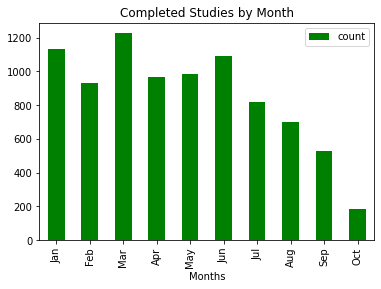

In [0]:
completed_studies.toPandas().plot(kind="bar", x="Months", y="count", title="Completed Studies by Month", color ='green')

In [0]:
completed_studies = completed_studies.select("Months", *[col for col in completed_studies.columns if col != "Months"])


In [0]:
completed_studies.toPandas()

,Months,count
0,Jan,1131
1,Feb,934
2,Mar,1227
3,Apr,967
4,May,984
5,Jun,1094
6,Jul,819
7,Aug,700
8,Sep,528
9,Oct,187


FURTHER ANALYSIS

CREATION OF USER DEFINED FUNCTION TO COUNT COLUMN ELEMENTS

In [0]:
from pyspark.sql.functions import desc, col
from pyspark.sql.types import IntegerType

# Define the UDF to extract the count from a Row object
def extract_count(row):
    if isinstance(row, int):
        return row
    else:
        return row['count']

# Register the UDF with Spark
extract_count_udf = udf(extract_count, IntegerType())

# Compute the Status counts
Status_counts = (clinicaltrial_df
                 .groupBy('Status')
                 .count()
                 .withColumn('count', extract_count_udf(col('count')))
                 .orderBy(desc('count'))
                )

Status_counts.toPandas()

,Status,count
0,Completed,209749
1,Recruiting,60950
2,Unknown status,44608
3,Terminated,22285
4,"Active, not recruiting",17848
5,Not yet recruiting,16499
6,Withdrawn,9973
7,Enrolling by invitation,3682
8,Suspended,1598
9,No longer available,39


In [0]:
# Compute the Sponsor counts
Sponsor_counts = (clinicaltrial_df
                 .groupBy('Sponsor')
                 .count()
                 .withColumn('count', extract_count_udf(col('count')))
                 .orderBy(desc('count'))
                )

Sponsor_counts.toPandas()

,Sponsor,count
0,GlaxoSmithKline,3378
1,National Cancer Institute (NCI),3218
2,AstraZeneca,2691
3,Pfizer,2645
4,M.D. Anderson Cancer Center,2414
...,...,...
34437,Hôpital Militaire De Rabat,1
34438,Bayfront Health St Petersburg,1
34439,H.K.E.S's S.Nijalingappa Institute of Dental S...,1
34440,"Organisation for Rural Community Development, ...",1


In [0]:
# Compute the Type counts
Type_counts = (clinicaltrial_df
                 .groupBy('Type')
                 .count()
                 .withColumn('count', extract_count_udf(col('count')))
                 .orderBy(desc('count'))
                )

Type_counts.toPandas()

,Type,count
0,Interventional,301472
1,Observational,77540
2,Observational [Patient Registry],8180
3,Expanded Access,69


POWERBI ANALYSIS

In [0]:
from pyspark.sql import functions as F

# Replace commas with " OR " in all columns of the DataFrame
clinicaltrial_df_BI = clinicaltrial_df.select([F.regexp_replace(col, ',', ' OR ').alias(col) for col in clinicaltrial_df.columns])

clinicaltrial_df_BI.show()

+-----------+--------------------+--------------------+--------+----------+--------------------+----------+--------------------+--------------------+
|         Id|             Sponsor|              Status|   Start|Completion|                Type|Submission|          Conditions|       Interventions|
+-----------+--------------------+--------------------+--------+----------+--------------------+----------+--------------------+--------------------+
|NCT02758028|The University of...|          Recruiting|Aug 2005|  Nov 2021|      Interventional|  Apr 2016|                null|                null|
|NCT02751957|     Duke University|           Completed|Jul 2016|  Jul 2020|      Interventional|  Apr 2016|Autistic Disorder...|                null|
|NCT02758483|Universidade Fede...|           Completed|Mar 2017|  Jan 2018|      Interventional|  Apr 2016|   Diabetes Mellitus|                null|
|NCT02759848|Istanbul Medeniye...|           Completed|Jan 2012|  Dec 2014|       Observational|  Ma

In [0]:
# Saving the newly created dataframe as a csv file name clinicaltrial_BI
clinicaltrial_df_BI.write.csv("/FileStore/tables/clinicaltrial_BI.csv", header=True, mode="overwrite")

In [0]:
%sql
--- creating a table named clinicaltrial_BI and writing the file into it
DROP TABLE IF EXISTS clinicaltrial_BI;
-- create the table using the CSV file
CREATE TABLE clinicaltrial_BI
USING csv
OPTIONS (
  path "dbfs:/FileStore/tables/clinicaltrial_BI.csv",
  header "true",
  schema "inferSchema"
);

In [0]:
%sql
show tables

database,tableName,isTemporary
default,clinicaltrial_bi,false


In [0]:
%sql
select * from clinicaltrial_BI

Id,Sponsor,Status,Start,Completion,Type,Submission,Conditions,Interventions
NCT04468815,Bristol-Myers Squibb,Not yet recruiting,Jul 2020,Oct 2020,Interventional,Jul 2020,null,Esomeprazole
NCT04463966,Benha University,Recruiting,Apr 2020,May 2021,Interventional,Apr 2020,Postpartum Hemorrhage OR Hemorrhage,Tranexamic Acid
NCT04462133,Incheon St.Mary's Hospital,Not yet recruiting,Sep 2020,Oct 2024,Interventional,Jun 2020,Infections OR Communicable Diseases,null
NCT04463589,University Hospital OR Lille,Not yet recruiting,Jan 2021,Jan 2023,Observational,Jul 2020,Asthma,null
NCT04466865,University of Wisconsin OR Madison,Enrolling by invitation,Nov 2020,Jan 2025,Interventional,Jul 2020,Kidney Diseases OR Kidney Failure OR Renal Insufficiency OR Death,null
NCT04469296,Institut du Cancer de Montpellier - Val d'Aurelle,Recruiting,Mar 2021,May 2022,Interventional,Jul 2020,Breast Neoplasms,null
NCT04463238,Peking University Third Hospital,Not yet recruiting,Aug 2020,Aug 2023,Interventional,Jul 2020,Wounds and Injuries,null
NCT04466124,National Cancer Center OR Korea,Enrolling by invitation,Sep 2018,Aug 2028,Observational,Jul 2020,Liver Neoplasms,null
NCT04465305,Peking University Third Hospital,Recruiting,Jul 2020,Jun 2022,Interventional,Jul 2020,Cysts OR Tarlov Cysts,null
NCT04469712,Aleris Hospital,Recruiting,Aug 2020,Aug 2027,Observational [Patient Registry],Jul 2020,Metabolic Syndrome OR Obesity OR Postoperative Complications,null


ONWARD FOR IMPORT INTO POWER BI INTERFACE..............................